Notebook to calculate the synchrotron emission from an arbitrary particle energy distribution

In [1]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt
import matplotlib.colors

from astropy.constants import G, alpha, c, e, hbar, m_e, m_p, sigma_sb, k_B, M_sun, R_sun, sigma_T, sigma_sb, h
from astropy import units as u

import naima
from naima.models import ExponentialCutoffPowerLaw, Synchrotron
from naima.utils import trapz_loglog

from auxiliary_functions import free_fall_time

u.default_system = 'cgs'
mec2 = m_e * c**2

In [2]:
# Nice-looking plots
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": 'serif',
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 18,
        "font.size": 18,
        "axes.linewidth":1,
        "axes.titlesize":16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "xtick.major.size": 5,     # major tick size in points
        "xtick.minor.size": 5,       # minor tick size in points
        "xtick.major.width": 1.4,     # major tick width in points
        "xtick.minor.width": 1.4,     # minor tick width in points
}
matplotlib.rcParams.update(nice_fonts)

### Define the system parameters

In [3]:
# Parameters of the WD
M_WD = 1.0 * u.M_sun 
T_WD = 1e5 * u.K 
R_WD = 1e9 * u.cm # 0.015 * R_sun
B = 1e3 * u.G

# Parameters of the system
dist = 1 * u.kpc 
#eta_Edd = 0.01                                                        # Eddington ratio, L_acc/L_edd
#L_acc = eta_Edd * 1.3e38 * (M_WD/M_sun) * u.erg / u.s                 # Accreted luminosity
Mdot_16 = 1.0                                                          # mass accretion rate in units of 1e16 g/s
L_acc = 1.3e33 * Mdot_16 * (M_WD/M_sun) * (1e9*u.cm/R_WD) * u.erg/u.s  # Accreted luminosity (Eq. 1.6 from FKR)
eta_NT = 0.01
L_inj = eta_NT * L_acc                                                 # Injected power in relativistic electrons


# Other derived parameters
v_sh = np.sqrt(G*M_WD/R_WD) .cgs
t_ff = free_fall_time(R_WD, M_WD)                                      # free-fall time
T_b = np.power( L_acc / (4 * np.pi * R_WD**2 * sigma_sb) , 0.25) .cgs  # blackbody temperature (Eq. 1.10 from FKR)
T_sh = ( G * M_WD * m_p / (3 * k_B * R_WD) ).cgs                       # temperature in the surface shock (Eq. 1.11 from FKR)

print(f'T_b = {T_b.value:.1e} {T_b.unit}')
print(f'T_sh = {T_sh.value:.1e} {T_sh.unit}')
print(f'v_sh = {v_sh.value:.1e} {v_sh.unit}')

T_b = 3.7e+04 K
T_sh = 5.4e+08 K
v_sh = 3.6e+08 cm / s


### Calculate the characteristic timescales

In [4]:
# Energies
Ee_min = 1e6 * u.eV                         # Electron minimum energy, arbitrary (1 MeV is canonical)
Ee_max = 3e12 * u.eV                        # Electron maximum energy (must be higher than E_cutoff!)
Ee = np.geomspace(Ee_min, Ee_max, 200)       # Energies to evaluate electron energy distribution
gamm = Ee/mec2                              # Lorentz factor   


# Relativistic bremsstrahlung
n = 1e15 * u.cm**-3
t_br = 1e15 * (u.cm**-3/n) * Ee / Ee * u.s  # Convert to vector  

# Inverse Compton
U_BB = ( (4 * sigma_sb / c ) * T_WD**4 ).cgs 
#U_rad = 1.5 * u.eV / u.cm**3
# U_rad = 0
r = 10 * R_WD                               # Just in case we want an emitter that is not on the surface
U_rad = U_BB * (R_WD/r)**2 
T_ad = k_B * T_WD / mec2                    # Adimensional temperature
gamm_dot = 5.5e17 * T_ad**3 * gamm * (np.log(1 + 0.55*gamm*T_ad))/(1 + 25*T_ad*gamm) 
gamm_dot *= (1 + 1.4*gamm*T_ad/(1 + 12 * gamm**2 * T_ad**2)) * (U_rad / U_BB)
t_ic = gamm / gamm_dot 

# Synchrotron
U_B = ( B.to("G").value**2 / (8 * np.pi) ) * u.erg * u.cm**-3 # U_B = B**2 / 8 pi, but astropy units has errors
t_sy = ( Ee / ( (4./3.) * sigma_T * c * gamm**2 * U_B ) ).cgs

# Acceleration
efi_ac = ( 2.0 * np.pi * ( c/v_sh )**2 ).cgs
t_ac = efi_ac * Ee.to("erg").value / (B.to("G").value * c.cgs.value * e.gauss.value) * u.s

### Plot the timescales

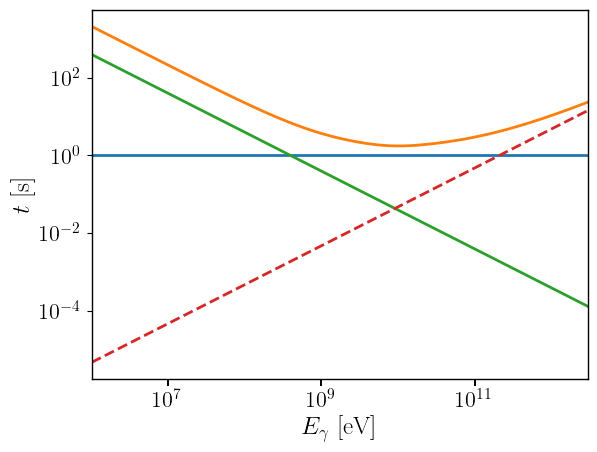

In [5]:
fig, ax = plt.subplots()

# Set labels
plt.title('')
plt.setp(ax, xlabel=r"$E_\gamma$ [eV]")
plt.setp(ax, ylabel=r"$t$ [s]")

plt.xlim(Ee_min.to("eV").value, Ee_max.to("eV").value)
#ymin, ymax = 1e33, 1e38 # For luminosities
#plt.ylim(ymin, ymax)

plt.plot(Ee, t_br, ls='-', linewidth=2, label='br', zorder=1)
plt.plot(Ee, t_ic, ls='-', linewidth=2, label='IC', zorder=1)
plt.plot(Ee, t_sy, ls='-', linewidth=2, label='sy', zorder=1)
plt.plot(Ee, t_ac, ls='--', linewidth=2, label='acc', zorder=1)
    
ax.loglog() 

plt.show()

### Define the particle energy distribution


Search for a self-consistent normalization taking into account the shape of $N(E)$. 
I assumed: $L_\mathrm{inj} = \int E \, Q(E) dE$, and $N(E) = Q(E) \, t_\mathrm{br}$.

If $t_\mathrm{br}$ is dominant (CHECK!) then $N(E) = N0 \times \, \mathrm{ECPL\_norm}$ to obtain the amplitude $N0$ for naima

In [6]:
alpha = 2.0                               # Spectral index (2 is canonical)
E_cutoff = 1e11 * u.eV                    # Electron cutoff energy, to be made self-consistent with cooling! at least by eye from the plot

norm = 1/u.eV
ECPL_norm = ExponentialCutoffPowerLaw(norm, 10*u.TeV, alpha, E_cutoff)
Ne_norm = ECPL_norm._calc(Ee) 
integral_Ne_norm = trapz_loglog(Ee*Ne_norm, Ee)
N0 = ( L_inj * t_br[0] / integral_Ne_norm ).cgs * norm

amplitude = N0 #   1 * u.Unit("1/eV") # ( (L_acc * t_ff / u.erg) / u.eV ).cgs 
ECPL = ExponentialCutoffPowerLaw(amplitude, 10*u.TeV, alpha, E_cutoff)
ECPL

### Calculate the synchrotron spectra

In [7]:
# Get syn sed
B = 1e-1 * u.G
distance = 1 * u.kpc
SYN = naima.models.Synchrotron(ECPL, B=B, Eemin=Ee_min)    

E_phmin_syn = 1e-7 * u.eV
E_phmax_syn = 1e4 * u.eV                # can be defined in terms of B and E_cutoff! 
nuc_max = 4.22e6 * B.to("G").value * max(gamm)**2 * u.Hz  # Maximum critical frequency of synchrotron photons
E_phmax_syn = (h * nuc_max).to("eV")
E_syn = np.geomspace(E_phmin_syn, E_phmax_syn, 400)
sed_syn = SYN.sed(E_syn, distance=0)    # =0 for luminosities, =dist for fluxes
#print(sed_syn)

# Get SSC SED
#Lsy = SYN.flux(data, distance=0*u.cm)
#R = 0.01 *  (1*u.pc).to(u.cm)
#c = 2.99792458e10 * u.cm / u.second
#phn_sy = Lsy / (4 * np.pi * R**2 * c) * 2.24 # This is the specific density of photons
#IC = naima.models.InverseCompton(Q, seed_photon_fields=[['SSC', data['energy'], phn_sy]], Eemin=Eemin)

E0 = k_B * T_WD                                  # Reference energy of the thermal photons
E_phmin_ic = 0.1 * E0
E_phmax_ic = 10 * E_cutoff
E_ic = np.geomspace(E_phmin_ic, E_phmax_ic, 400)

# Characterize the seed photon field with a name, temperature, and energy density. 
# If U_rad is set to 0, the energy density is computed through the Stefan-Boltzmann law (emitter embedded in the WD)
IC = naima.models.InverseCompton( ECPL, seed_photon_fields=[['WD', T_WD, U_rad]] ) 
sed_ic = IC.sed(E_ic, distance=0) # =0 for luminosities, =dist for fluxes
#print(sed_ic)

### Plot the results

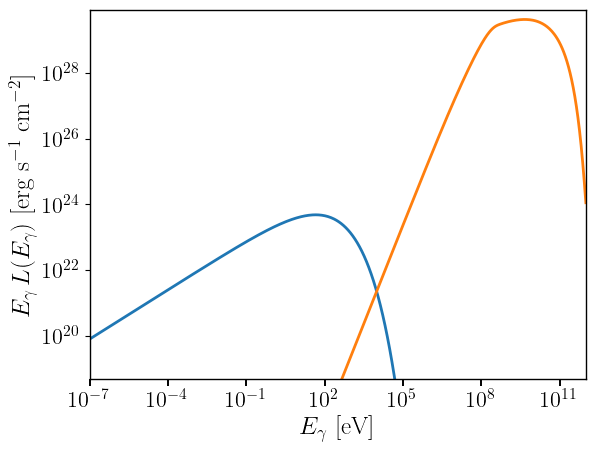

In [8]:
fig, ax = plt.subplots()

# Set labels
plt.title('')
plt.setp(ax, xlabel=r"$E_\gamma$ [eV]")
plt.setp(ax, ylabel=r"$E_\gamma \, L(E_\gamma)$ [erg s$^{-1}$ cm$^{-2}$]")

plt.xlim(E_phmin_syn.to("eV").value, E_phmax_ic.to("eV").value)
ymin, ymax = max(sed_syn.value)/1e5 , max(sed_ic.value)*2 
#ymin, ymax = 1e31, 1e38 # For luminosities
plt.ylim(ymin, ymax)

plt.plot(E_syn, sed_syn, ls='-', linewidth=2, label='syn', zorder=1)
plt.plot(E_ic, sed_ic, ls='-', linewidth=2, label='IC', zorder=1)
    
ax.loglog() 

plt.show()